<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

<img src='https://github.com/DJCordhose/ai/blob/master/notebooks/2019_tf/img/autoencoder_schema.jpg?raw=1'>

https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [0]:
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

## Dense Autoencoder

In [0]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding
from tensorflow.keras.models import Sequential, Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(units=784, activation='sigmoid', name="decoder")(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)

# loss on pixel level
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [4]:
BATCH_SIZE = 256

# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

%time history = autoencoder.fit(x_train, x_train, epochs=60, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_test, x_test), verbose=0)

CPU times: user 1min 22s, sys: 11.4 s, total: 1min 33s
Wall time: 1min 9s


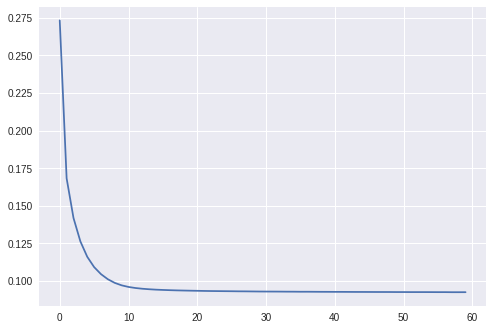

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [6]:
autoencoder.evaluate(x_train, x_train, batch_size=BATCH_SIZE)

60000/60000 [==============================] - 1s 10us/step


0.09250659470558166

In [0]:
# this model maps an input to its encoded representation
encoder = Model(inputs=input_img, outputs=encoded)

In [0]:
latent_representation = encoder.predict(x_test)

In [9]:
# compressed version of the image
len(latent_representation[0])

32

In [0]:
# let's see if we can reproduce it
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.get_layer("decoder")
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [0]:
# reproduce using decoder
decoded_imgs = decoder.predict(latent_representation)

In [12]:
len(decoded_imgs[0])

784

In [0]:
def plot(original, decoded, n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(original[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

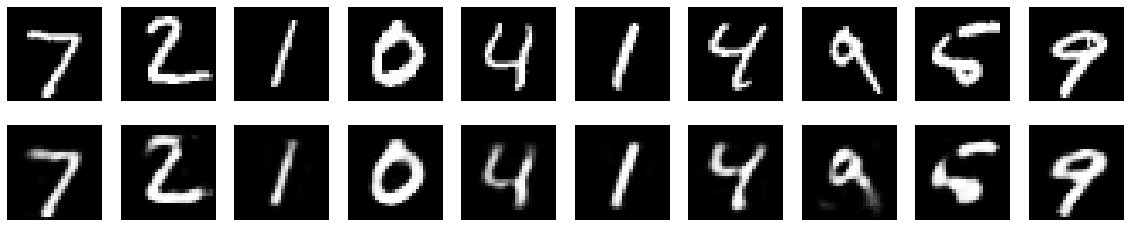

In [14]:
plot(x_test, decoded_imgs)

## Convolutional AE

In [0]:
from tensorflow.keras.layers import Input, Flatten, GlobalAveragePooling1D, Dense, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoder')(x)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)

# loss on pixel level
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [16]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

BATCH_SIZE = 128
%time history = autoencoder.fit(x_train, x_train, epochs=60, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_test, x_test), verbose=0)

Using TensorFlow backend.


CPU times: user 4min 55s, sys: 1min, total: 5min 56s
Wall time: 5min 4s


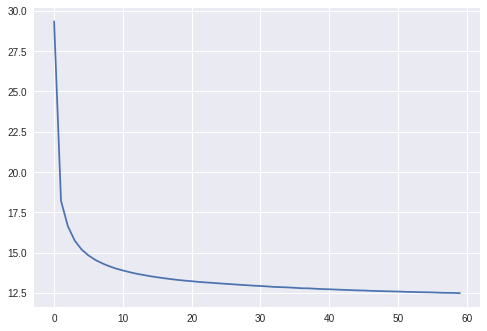

In [17]:
plt.plot(history.history['loss'])

In [18]:
autoencoder.evaluate(x_train, x_train, batch_size=BATCH_SIZE)

60000/60000 [==============================] - 2s 27us/step


12.463270434570312

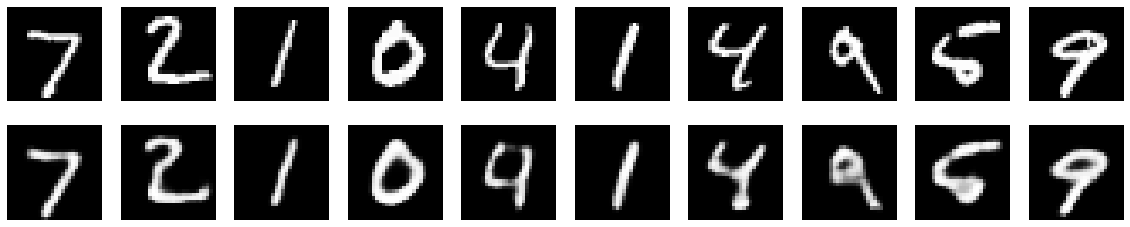

In [19]:
decoded_imgs = autoencoder.predict(x_test)
plot(x_test, decoded_imgs)

## On tabular data

In [20]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   163k      0 --:--:-- --:--:-- --:--:--  163k


In [0]:
import pandas as pd

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
X = df.as_matrix()

In [25]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [26]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [105]:
encoding_dim = 32

input_data = Input(shape=(4,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 4)                 0         
_________________________________________________________________
encoder (Dense)              (None, 32)                160       
_________________________________________________________________
decoder (Dense)              (None, 4)                 132       
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________


In [106]:
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 880.1991
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 5.3258
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7465
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4289
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3018
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2031
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1305
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0783
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0423
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0250
CPU times: user 33.9 s, sys: 4.12 s, total: 38 s
Wall time: 28.4 s


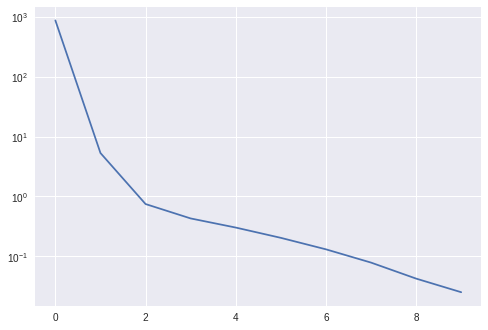

In [107]:
plt.yscale('log')
plt.plot(history.history['loss'])

In [108]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 2s 1ms/step


0.013800594099409258

In [0]:
samples = df.sample(10)

In [110]:
samples

,speed,age,miles,group
889,150.0,34.0,44.0,0
381,138.0,49.0,42.0,1
1258,118.0,16.0,36.0,0
619,151.0,33.0,50.0,0
281,127.0,100.0,30.0,2
1459,102.0,29.0,15.0,2
537,99.0,26.0,21.0,2
449,136.0,67.0,15.0,0
1158,121.0,24.0,59.0,2
54,104.0,81.0,11.0,0


In [111]:
pd.DataFrame(autoencoder.predict(samples))

,0,1,2,3
0,150.031738,34.048248,44.013069,-0.021331
1,138.029053,49.047890,42.016216,0.936554
2,118.122841,16.149437,35.980061,0.009331
3,151.037476,33.051556,50.012684,-0.026286
4,126.990265,100.035492,30.023317,1.877178
5,102.091164,29.083841,15.012420,1.972497
6,99.111816,26.097298,21.010746,1.975493
7,136.021805,67.055756,15.014413,0.000822
8,121.057190,24.083225,58.958145,1.932613
9,103.695145,80.601059,10.960476,-0.457809


## Looks quite nice, but how impressed are you by abstracting 4 variables into 32?

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 3819.9312
Epoch 2/10
1500/1500 [==============================] - 3s 2ms/step - loss: 2441.9827
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1573.4016
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 1001.8260
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 627.6026
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 399.6266
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 279.0252
Epoch 8/10
1500/1500 [==============================] - 3s 2ms/step - loss: 227.8077
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 212.5129
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 209.5579
CPU times: user 36.1 s, sys: 4.29 s, total: 40.4 s
Wall time: 30.6 s


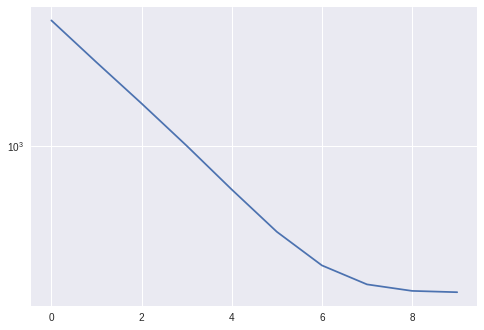

In [123]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice tanh
encoded = Dense(units=encoding_dim, activation='tanh', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# this does not get much better than 210 as a loss (bad), so we can just as well get there a bit faster (10 instead of 50 epochs with standard lr)
adam = keras.optimizers.Adam(lr=0.01)
# adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 2
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [124]:
autoencoder.evaluate(X, X, batch_size=BATCH_SIZE)

1500/1500 [==============================] - 2s 1ms/step


209.07847285970053

In [125]:
samples

,speed,age,miles,group
889,150.0,34.0,44.0,0
381,138.0,49.0,42.0,1
1258,118.0,16.0,36.0,0
619,151.0,33.0,50.0,0
281,127.0,100.0,30.0,2
1459,102.0,29.0,15.0,2
537,99.0,26.0,21.0,2
449,136.0,67.0,15.0,0
1158,121.0,24.0,59.0,2
54,104.0,81.0,11.0,0


In [126]:
# just average over all of them :D
pd.DataFrame(autoencoder.predict(samples))

,0,1,2,3
0,122.012787,44.932346,30.460308,1.142537
1,122.012787,44.932346,30.460308,1.142537
2,122.012787,44.932346,30.460308,1.142537
3,122.012787,44.932346,30.460308,1.142537
4,122.012787,44.932346,30.460308,1.142537
5,122.012787,44.932346,30.460308,1.142537
6,122.012787,44.932346,30.460308,1.142537
7,122.012787,44.932346,30.460308,1.142537
8,122.012787,44.932346,30.460308,1.142537
9,122.012787,44.932346,30.460308,1.142537


In [127]:
samples.describe()

,speed,age,miles,group
count,10.000000,10.000000,10.000000,10.000000
mean,124.600000,45.900000,32.300000,0.900000
std,19.161304,27.842613,16.519685,0.994429
min,99.000000,16.000000,11.000000,0.000000
25%,107.500000,26.750000,16.500000,0.000000
50%,124.000000,33.500000,33.000000,0.500000
75%,137.500000,62.500000,43.500000,2.000000
max,151.000000,100.000000,59.000000,2.000000


Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 3030.8858
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 136.6676
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 92.0838
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 52.6472
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 39.4809
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 37.7274
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 37.2088
Epoch 8/10
1500/1500 [==============================] - 6s 4ms/step - loss: 37.0957
Epoch 9/10
1500/1500 [==============================] - 6s 4ms/step - loss: 36.8773
Epoch 10/10
1500/1500 [==============================] - 6s 4ms/step - loss: 36.7422
CPU times: user 1min 9s, sys: 8.22 s, total: 1min 17s
Wall time: 58.5 s


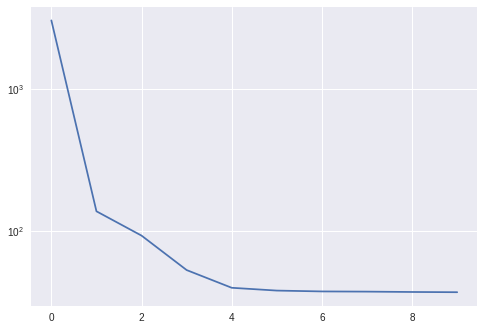

In [130]:
encoding_dim = 2

input_data = Input(shape=(4,))
# notice tanh
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [132]:
samples

,speed,age,miles,group
889,150.0,34.0,44.0,0
381,138.0,49.0,42.0,1
1258,118.0,16.0,36.0,0
619,151.0,33.0,50.0,0
281,127.0,100.0,30.0,2
1459,102.0,29.0,15.0,2
537,99.0,26.0,21.0,2
449,136.0,67.0,15.0,0
1158,121.0,24.0,59.0,2
54,104.0,81.0,11.0,0


In [131]:
# all groups close to 1, all off as they might not add to a big error
pd.DataFrame(autoencoder.predict(samples))

,0,1,2,3
0,149.421494,34.718063,46.773655,1.082367
1,139.608154,47.930485,38.801693,1.081315
2,117.370621,17.289089,39.710648,0.879606
3,152.079605,32.410206,48.534939,1.086833
4,130.899460,96.906387,20.060331,1.202943
5,97.787437,32.890175,27.173672,0.842087
6,96.776131,28.389120,28.188282,0.822690
7,131.229935,71.070770,28.281042,1.119438
8,127.655281,19.132721,43.151257,0.932334
9,103.428123,82.192604,13.936083,1.029894


### Let the group count a bit more (normalizing all values might also do the trick)

In [0]:
# let the group count a bit more (normalizing all values might also do the trick)
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
df['group'] = df['group'] * 100
X = df.as_matrix()

Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 2265.3487
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 196.5072
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 129.9112
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 119.4161
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 115.0911
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 113.7378
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 113.5985
Epoch 8/10
1500/1500 [==============================] - 6s 4ms/step - loss: 113.9276
Epoch 9/10
1500/1500 [==============================] - 6s 4ms/step - loss: 113.7838
Epoch 10/10
1500/1500 [==============================] - 6s 4ms/step - loss: 113.7668
CPU times: user 1min 11s, sys: 8.13 s, total: 1min 19s
Wall time: 1min


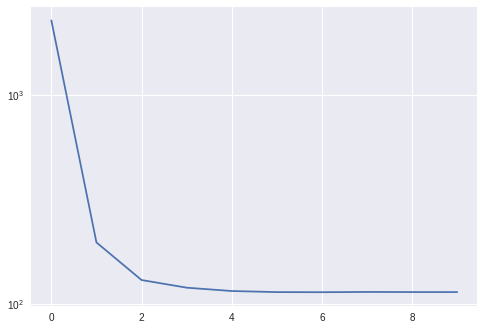

In [150]:
encoding_dim = 2

input_data = Input(shape=(4,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=4, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(X, X, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
samples = df.sample(10)

In [152]:
samples

,speed,age,miles,group
121,99.0,39.0,19.0,100
1041,117.0,67.0,23.0,0
110,104.0,30.0,23.0,100
1363,115.0,38.0,41.0,100
52,157.0,40.0,48.0,0
579,139.0,47.0,40.0,100
1135,118.0,39.0,17.0,200
1233,99.0,31.0,7.0,200
660,104.0,16.0,15.0,200
1112,141.0,53.0,27.0,200


In [153]:
pd.DataFrame(autoencoder.predict(samples))

,0,1,2,3
0,98.057281,38.062424,25.081690,100.143311
1,122.523232,44.983093,32.430145,0.552424
2,100.379326,38.897167,25.707376,99.923767
3,115.851311,44.484921,29.865986,99.798943
4,152.999405,55.977123,40.626682,-0.343766
5,138.110535,52.529266,35.846729,99.897621
6,112.920975,45.358597,28.299204,200.082794
7,92.633942,38.029594,22.847313,200.127884
8,94.052338,38.534874,23.231367,199.754410
9,138.300873,54.529461,35.118942,200.129044


### We might also try a one hot encoding for the group and normalizing all data (clumsy, though)

In [0]:
from tensorflow.keras.utils import to_categorical

df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

one_hot_groups = to_categorical(df['group'])
df['yellow'] = one_hot_groups[:, 0] * 150
df['green'] = one_hot_groups[:, 1] * 150
df['red'] = one_hot_groups[:, 2] * 150

df['age'] = df['age'] * 3 
df['miles'] = df['miles'] * 4 

df.drop('group', axis='columns', inplace=True)

In [186]:
df.head()

,speed,age,miles,yellow,green,red
0,98.0,132.0,100.0,0.0,150.0,0.0
1,118.0,162.0,96.0,0.0,150.0,0.0
2,111.0,78.0,136.0,150.0,0.0,0.0
3,97.0,75.0,40.0,0.0,0.0,150.0
4,114.0,114.0,88.0,0.0,150.0,0.0


Epoch 1/10
1500/1500 [==============================] - 9s 6ms/step - loss: 7881.8887
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 3493.6779
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 3126.6512
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 2428.6396
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 2086.2063
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 2008.1455
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 1984.1852
Epoch 8/10
1500/1500 [==============================] - 6s 4ms/step - loss: 1978.1467
Epoch 9/10
1500/1500 [==============================] - 6s 4ms/step - loss: 1972.9973
Epoch 10/10
1500/1500 [==============================] - 6s 4ms/step - loss: 1971.3653
CPU times: user 1min 14s, sys: 7.94 s, total: 1min 22s
Wall time: 1min 2s


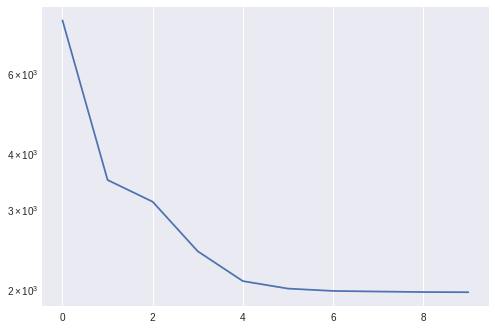

In [187]:
features = 6

encoding_dim = 2

input_data = Input(shape=(features,))
encoded = Dense(units=encoding_dim, activation='relu', name="encoder")(input_data)
decoded = Dense(units=features, activation='linear', name="decoder")(encoded)

autoencoder = Model(inputs=input_data, outputs=decoded)
# adam = keras.optimizers.Adam(lr=0.01)
adam = keras.optimizers.Adam()
autoencoder.compile(optimizer=adam, loss='mse')
BATCH_SIZE = 1
%time history = autoencoder.fit(df, df, epochs=10, batch_size=BATCH_SIZE, shuffle=True, verbose=1)
plt.yscale('log')
plt.plot(history.history['loss'])

In [188]:
samples = df.sample(10)
samples

,speed,age,miles,yellow,green,red
567,138.0,204.0,224.0,0.0,0.0,150.0
189,120.0,57.0,132.0,150.0,0.0,0.0
1129,116.0,96.0,104.0,150.0,0.0,0.0
323,97.0,84.0,208.0,150.0,0.0,0.0
1246,145.0,111.0,204.0,150.0,0.0,0.0
1062,115.0,87.0,132.0,150.0,0.0,0.0
715,105.0,168.0,136.0,0.0,150.0,0.0
192,155.0,207.0,212.0,0.0,0.0,150.0
218,124.0,102.0,196.0,0.0,0.0,150.0
1065,106.0,174.0,220.0,0.0,0.0,150.0


In [189]:
pd.DataFrame(autoencoder.predict(samples))

,0,1,2,3,4,5
0,169.519379,195.707840,176.339096,53.343018,85.666245,65.480385
1,100.441498,105.343971,117.532600,134.072403,-34.469772,11.532813
2,103.221497,108.962746,119.924782,131.014282,-29.793245,13.653645
3,125.097076,133.115921,144.928802,153.100525,-31.277531,18.185053
4,140.589478,151.920700,160.207153,150.598862,-17.278152,26.173634
5,108.197487,114.431458,125.648651,136.308960,-30.355476,14.613065
6,131.186417,155.728058,129.172440,-10.387737,109.029480,64.133133
7,170.175781,196.821259,176.533676,49.856083,89.064018,66.709488
8,129.707321,149.036453,134.714081,42.126019,64.328758,49.599838
9,153.874405,176.998032,160.509705,52.878044,74.010368,58.201107
